# Build Model SureVenir

SureVenir ....




## Imports Library

In [1]:
import os
import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam


## Prepare the Dataset

In [2]:
# Define the path of dataset directory
dataset_path  = "./dataset-ml"

In [3]:
# Parameter untuk preprocessing
img_height, img_width = 224, 224  

def load_and_preprocess_data(directory):
    images = []
    labels = []
    class_counts = {}
    class_names = sorted(os.listdir(directory))  
    class_labels = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name, label in class_labels.items():
        class_folder = os.path.join(directory, class_name)
        class_counts[class_name] = 0

        for filename in os.listdir(class_folder):
            file_path = os.path.join(class_folder, filename)
            try:
                image = Image.open(file_path).convert("RGB")
                image = image.resize((img_width, img_height))
                image_array = np.array(image, dtype=np.float32) / 255.0
                images.append(image_array)
                labels.append(label)
                class_counts[class_name] += 1
            except Exception as e:
                print(f"Error loading image {file_path}: {e}")

    num_classes = len(class_names)
    labels_one_hot = np.eye(num_classes)[labels]  

    return np.array(images), labels_one_hot, class_labels, class_counts

images, labels_one_hot, class_labels, class_counts = load_and_preprocess_data(dataset_path)

total_images = len(images)
shape_images = images.shape
shape_labels = labels_one_hot.shape

class_counts_df = pd.DataFrame(list(class_counts.items()), columns=['Class Name', 'Number of Images'])

print(f"Total images: {total_images}")
print(f"Shape of image data: {shape_images}")
print(f"Shape of label data: {shape_labels}")
print(f"Class labels (numeric): {class_labels}")
print("\nNumber of images per class:")

print(class_counts_df)

Total images: 6690
Shape of image data: (6690, 224, 224, 3)
Shape of label data: (6690, 21)
Class labels (numeric): {'Aromatherapy Candle': 0, 'Balinese Topeng': 1, 'Barong T-shirt': 2, 'Beach Hat Bali': 3, 'Beach Sarong': 4, 'Beads Bracelet': 5, 'Bintang T-shirt': 6, 'Coconut Shell Candle Holder': 7, 'Crochet Bag': 8, 'Dream Catcher': 9, 'Hair Clip': 10, 'Handy Fan': 11, 'Keben (Balinese Woven Box)': 12, 'Keychain': 13, 'Rattan bag': 14, 'Silver Earrings': 15, 'Tridatu Bracelet': 16, 'Udeng (Balinese Headgear)': 17, 'Wall Decoration': 18, 'Wooden Earrings': 19, 'Woven Bag': 20}

Number of images per class:
                     Class Name  Number of Images
0           Aromatherapy Candle               305
1               Balinese Topeng               311
2                Barong T-shirt               300
3                Beach Hat Bali               401
4                  Beach Sarong               301
5                Beads Bracelet               307
6               Bintang T-shirt    

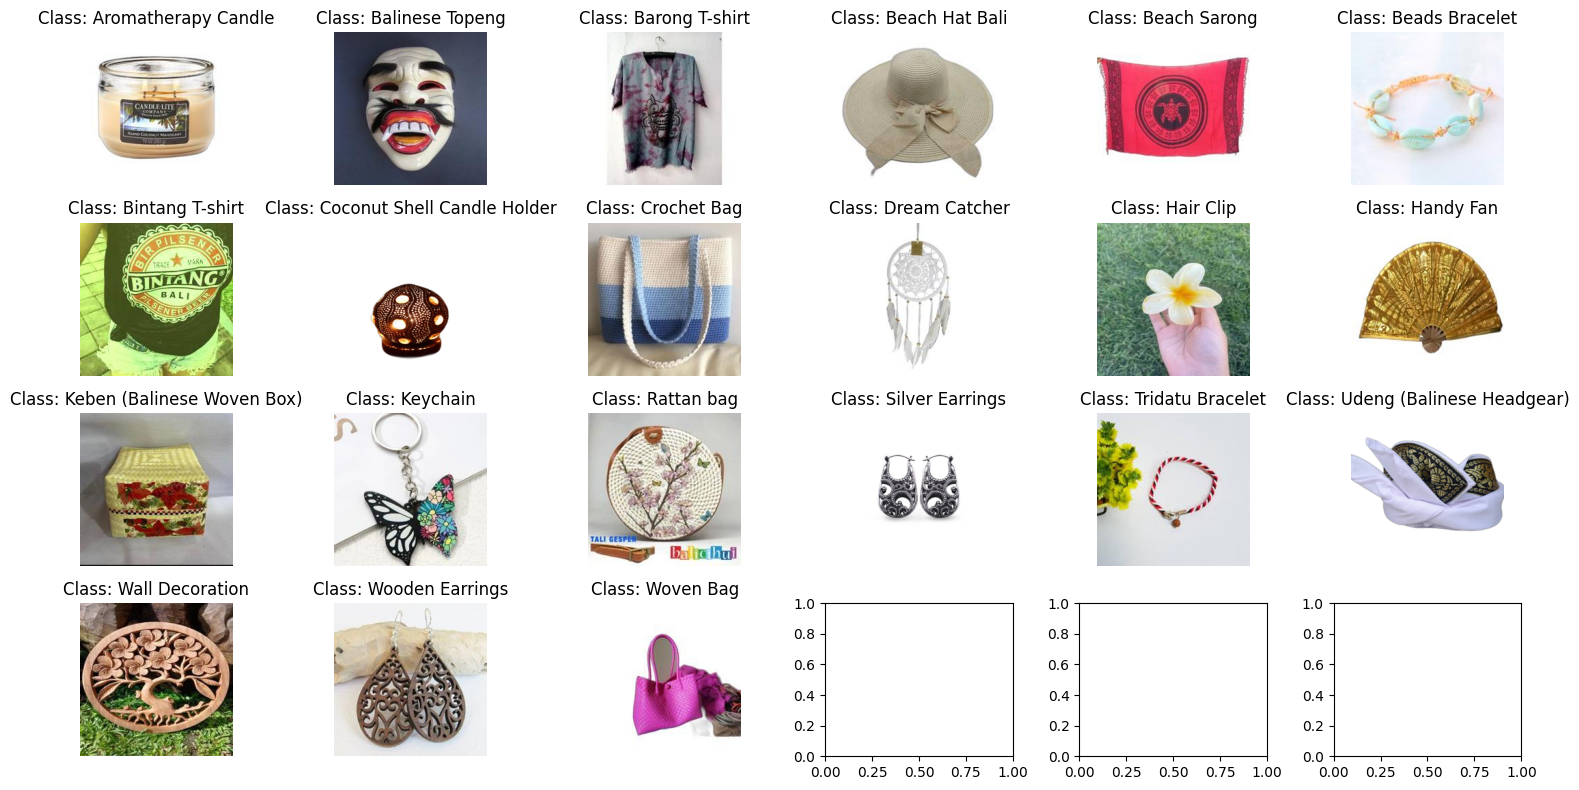

In [4]:
fig, axes = plt.subplots(4, 6, figsize=(15, 8))  
axes = axes.flatten()  


for idx, (class_name, class_label) in enumerate(class_labels.items()):
    if idx >= len(axes):  
        break
    
    class_indices = np.where(np.argmax(labels_one_hot, axis=1) == class_label)[0]
    if len(class_indices) == 0:
        continue
    
    img = images[class_indices[0]]
    axes[idx].imshow(img)
    axes[idx].set_title(f'Class: {class_name}')
    axes[idx].axis('off')  

plt.tight_layout()
plt.show()

SPLIT THE DATASET


In [5]:
def split_data(images, labels, class_labels, dataset_path, split_ratio=(0.80, 0.20)):
    
    if sum(split_ratio) != 1.0:
        raise ValueError("Split ratio harus bernilai 1.0 jika dijumlahkan.")
    
    
    train_path = os.path.join(dataset_path, 'train')
    test_path = os.path.join(dataset_path, 'test')

    
    for path in [train_path, test_path]:
        os.makedirs(path, exist_ok=True)
    
   
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=split_ratio[1], stratify=labels)
    
   
    def save_images(images, labels, folder_path):
        for idx, image in enumerate(images):
            image = (image * 255).astype(np.uint8)  
            label_index = np.argmax(labels[idx])  
            class_name = [name for name, value in class_labels.items() if value == label_index][0]
            class_folder = os.path.join(folder_path, class_name)
            os.makedirs(class_folder, exist_ok=True)
            image_path = os.path.join(class_folder, f"{idx}.jpg")
            Image.fromarray(image).save(image_path)
    
   
    save_images(train_images, train_labels, train_path)
    save_images(test_images, test_labels, test_path)

    print(f"Data successfully split into folders:\n- Train: {len(train_images)}\n- Test: {len(test_images)}")


split_data(images, labels_one_hot, class_labels, dataset_path)

Data successfully split into folders:
- Train: 5352
- Test: 1338


In [6]:
def calculate_data_distribution(directory):
    class_counts = {}
    class_names = sorted(os.listdir(directory))
    
    for class_name in class_names:
        class_folder = os.path.join(directory, class_name)  
        if os.path.isdir(class_folder):
            num_images = len(os.listdir(class_folder))
            class_counts[class_name] = num_images
    return class_counts

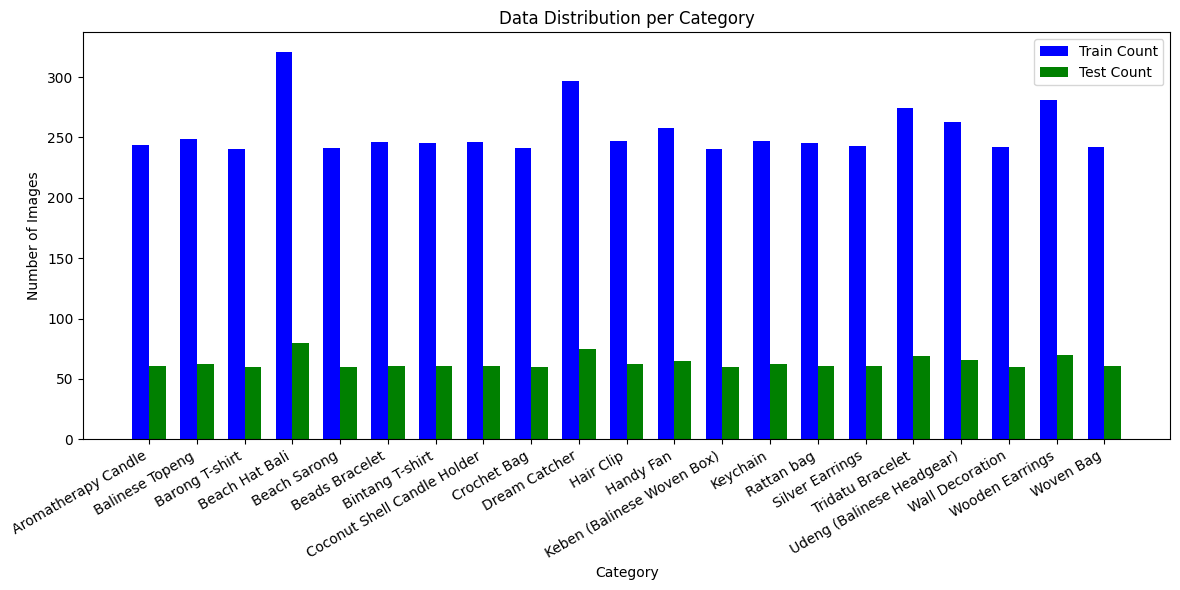

In [7]:
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

# Hitung distribusi data
train_counts = calculate_data_distribution(train_path)
test_counts = calculate_data_distribution(test_path)

# Membuat visualisasi distribusi data
categories = list(train_counts.keys())
train_values = [train_counts.get(cat, 0) for cat in categories]
test_values = [test_counts.get(cat, 0) for cat in categories]

x = np.arange(len(categories))  # Lokasi untuk kategori
width = 0.35  # Lebar setiap bar

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_values, width, label='Train Count', color='blue')
plt.bar(x + width/2, test_values, width, label='Test Count', color='green')

# Pengaturan visualisasi
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Data Distribution per Category')
plt.xticks(x, categories, rotation=30, ha='right')
plt.legend()
plt.tight_layout()

# Tampilkan grafik
plt.show()

DATA AUGMENTASI


In [8]:
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

training_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    channel_shift_range=50.0,
    shear_range=0.2,
    zoom_range=0.2, 
    width_shift_range=0.2,            
    height_shift_range=0.2,          
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(img_height, img_width),
	class_mode='categorical',
    batch_size=15
)

validation_generator = validation_datagen.flow_from_directory(
	test_dir,
	target_size=(img_height, img_width),
	class_mode='categorical',
    batch_size=15
)

print("Training and validation datasets are ready..")

Found 5352 images belonging to 21 classes.
Found 1338 images belonging to 21 classes.
Training and validation datasets are ready..


## Build the Model

In [9]:
base_model = MobileNetV2(weights='imagenet',
                         include_top=False,
                         input_shape=(img_height, img_width, 3))

base_model.trainable = False

# Create a new model on top of the pre-trained model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(21, activation='softmax')
])

# Print the model summary
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 21)                10773     
                                                                 
Total params: 2924629 (11.16 MB)
Trainable params: 666

In [10]:
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [11]:
history = model.fit(
    train_generator,
    epochs=10,  # Train top layers first
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    ]
)

Epoch 1/10


357/357 [==============================] - 92s 249ms/step - loss: 0.7399 - accuracy: 0.7799 - val_loss: 0.2778 - val_accuracy: 0.9096
Epoch 2/10
357/357 [==============================] - 82s 231ms/step - loss: 0.3422 - accuracy: 0.8948 - val_loss: 0.2271 - val_accuracy: 0.9305
Epoch 3/10
357/357 [==============================] - 82s 230ms/step - loss: 0.2757 - accuracy: 0.9129 - val_loss: 0.1994 - val_accuracy: 0.9387
Epoch 4/10
357/357 [==============================] - 82s 229ms/step - loss: 0.2475 - accuracy: 0.9217 - val_loss: 0.1675 - val_accuracy: 0.9514
Epoch 5/10
357/357 [==============================] - 82s 231ms/step - loss: 0.2132 - accuracy: 0.9354 - val_loss: 0.2013 - val_accuracy: 0.9350
Epoch 6/10
357/357 [==============================] - 82s 230ms/step - loss: 0.2192 - accuracy: 0.9322 - val_loss: 0.1682 - val_accuracy: 0.9514
Epoch 7/10
357/357 [==============================] - 82s 231ms/step - loss: 0.1918 - accuracy: 0.9382 - val_loss: 0.1445 - val_

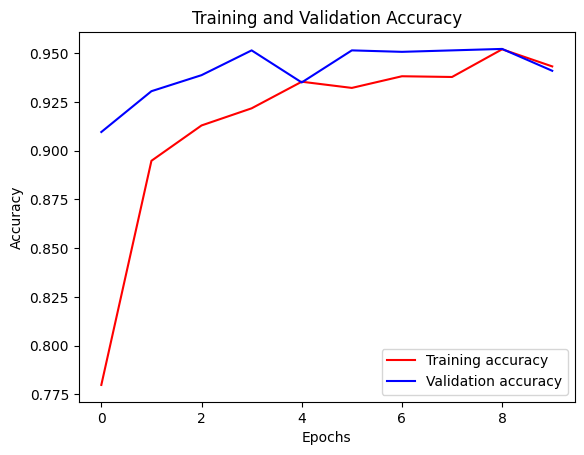

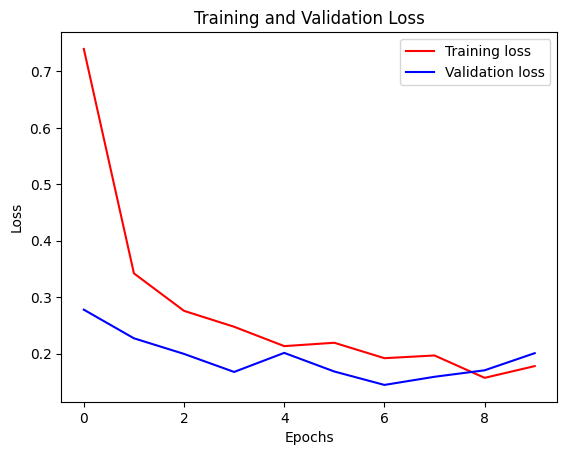

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

# Plot Akurasi Training dan Validation
plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Loss Training dan Validation
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [13]:
# Fine-tune the model (unfreeze some layers in the base model)
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30 

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the entire model with fine-tuning
fine_tune_history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

# Evaluate on the test dataset
test_loss, test_acc = model.evaluate(validation_generator)
print(f"Test accuracy after fine-tuning: {test_acc * 100:.2f}%")
print(f"Test loss after fine-tuning: {test_loss * 100:.2f}%")

Epoch 1/15
357/357 [==============================] - 121s 326ms/step - loss: 0.2875 - accuracy: 0.9146 - val_loss: 0.1840 - val_accuracy: 0.9484
Epoch 2/15
357/357 [==============================] - 692s 2s/step - loss: 0.1975 - accuracy: 0.9391 - val_loss: 0.1684 - val_accuracy: 0.9596
Epoch 3/15
357/357 [==============================] - 114s 319ms/step - loss: 0.1521 - accuracy: 0.9503 - val_loss: 0.1348 - val_accuracy: 0.9611
Epoch 4/15
357/357 [==============================] - 105s 294ms/step - loss: 0.1338 - accuracy: 0.9602 - val_loss: 0.1604 - val_accuracy: 0.9626
Epoch 5/15
357/357 [==============================] - 108s 303ms/step - loss: 0.1192 - accuracy: 0.9615 - val_loss: 0.1636 - val_accuracy: 0.9641
Epoch 6/15
357/357 [==============================] - 153s 428ms/step - loss: 0.0942 - accuracy: 0.9699 - val_loss: 0.1464 - val_accuracy: 0.9723
Epoch 7/15
357/357 [==============================] - 125s 351ms/step - loss: 0.1035 - accuracy: 0.9705 - val_loss: 0.1206 - va

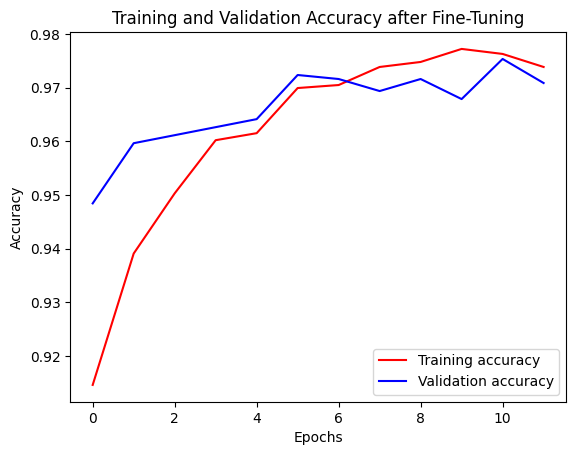

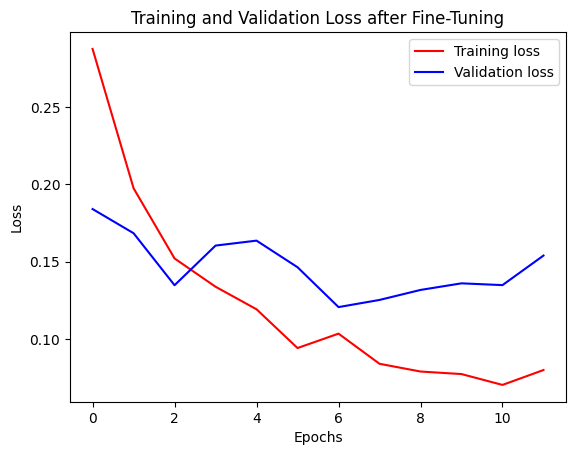

In [14]:
acc = fine_tune_history.history['accuracy']
val_acc = fine_tune_history.history['val_accuracy']
loss = fine_tune_history.history['loss']
val_loss = fine_tune_history.history['val_loss']

epochs = range(len(acc))

# Plot Akurasi Training dan Validation
plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy after Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot Loss Training dan Validation
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss after Fine-Tuning')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

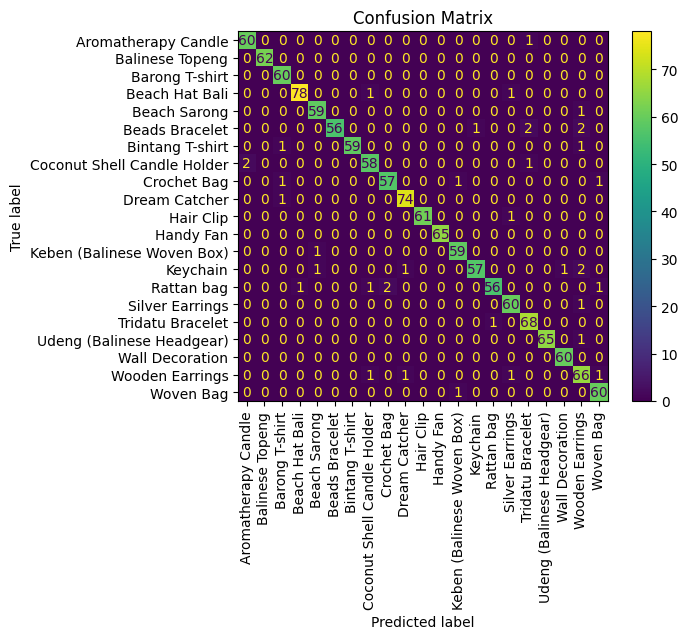

In [15]:
y_true = []
y_pred = []

for batch_images, batch_labels in validation_generator:

    predictions = model.predict(batch_images, verbose=0)
    
    y_true.extend(np.argmax(batch_labels, axis=1))
    
    y_pred.extend(np.argmax(predictions, axis=1))
    
    if len(y_true) >= validation_generator.samples:
        break

classes = {v: k for k, v in validation_generator.class_indices.items()}

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.values()))
disp.plot(cmap="viridis", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

In [16]:
# Classification Report
report = classification_report(y_true, y_pred, target_names=list(classes.values()))
print("Classification Report:")
print(report)

Classification Report:
                             precision    recall  f1-score   support

        Aromatherapy Candle       0.97      0.98      0.98        61
            Balinese Topeng       1.00      1.00      1.00        62
             Barong T-shirt       0.95      1.00      0.98        60
             Beach Hat Bali       0.99      0.97      0.98        80
               Beach Sarong       0.97      0.98      0.98        60
             Beads Bracelet       1.00      0.92      0.96        61
            Bintang T-shirt       1.00      0.97      0.98        61
Coconut Shell Candle Holder       0.95      0.95      0.95        61
                Crochet Bag       0.97      0.95      0.96        60
              Dream Catcher       0.97      0.99      0.98        75
                  Hair Clip       1.00      0.98      0.99        62
                  Handy Fan       1.00      1.00      1.00        65
 Keben (Balinese Woven Box)       0.97      0.98      0.98        60
          

In [17]:
import json
import numpy as np
import tensorflow as tf
from PIL import Image

# Load classes with the updated order
classes = {
    0: "aromatherapy-candle",
    1: "balinese-topeng",
    2: "barong-t-shirt",
    3: "beach-hat-bali",
    4: "beach-sarong",
    5: "beads-bracelet",
    6: "bintang-t-shirt",
    7: "coconut-shell-candle-holder",
    8: "crochet-bag",
    9: "dream-catcher",
    10: "hair-clip",
    11: "handy-fan",
    12: "keben-balinese-woven-box",
    13: "keychain",
    14: "rattan-bag",
    15: "silver-earrings",
    16: "tridatu-bracelet",
    17: "udeng-balinese-headgear",
    18: "wall-decoration",
    19: "wooden-earrings",
    20: "woven-bag"
}

# Function to load JSON data
def load_json(file_path):
    try:
        with open(file_path, "r") as file:
            data = json.load(file)
        # Create a dictionary with numeric ID as keys
        return {idx: item for idx, item in enumerate(data)}
    except Exception as e:
        print(f"Error loading JSON: {e}")
        return {}

# Function to predict image
def predict_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        image = image.resize((img_height, img_width))  # Resize image to the required input size
        image_array = tf.keras.utils.img_to_array(image) / 255.0  # Normalize the image
        image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
        
        prediction = model.predict(image_array, verbose=0)[0]
        
        predicted_class_id = np.argmax(prediction)
        predicted_class = classes[predicted_class_id]
        confidence = np.max(prediction) * 100
        return predicted_class, predicted_class_id, confidence
    except Exception as e:
        return f"Error: {e}", None, None

# Load JSON data
descriptions = load_json("description.json")

# Test with an image path
image_path = "predict7.jpg"
predicted_class, predicted_class_id, confidence = predict_image(image_path)

# Print results
if confidence is not None:
    print(f"\nPredicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")
    
    # Get item details from JSON using the predicted class ID
    if predicted_class_id in descriptions:
        item = descriptions[predicted_class_id]
        print(f"Name: {item['Name']}")
        print(f"Description: {item['Description']}")
        print(f"Price Range: {item['Price Range']}")
        print(f"Purchase Location: {item['Purchase Location']}")
    else:
        print("No matching item found in the JSON file.")
else:
    print(predicted_class)



Predicted Class: barong-t-shirt
Confidence: 100.00%
Name: Barong T-shirt
Description: The Barong T-Shirt is a unique and stylish garment that features the iconic Barong, a mythical creature symbolizing protection and good spirits in Balinese culture. Crafted from high-quality rayon material, this t-shirt is soft, lightweight, and perfect for casual wear or as a meaningful souvenir from Bali.

Available in a variety of sizes to ensure the perfect fit:

- S: Width: 50cm, Length 55cm
- M: Width: 52cm, Length 58cm
- L: Width 54cm, Length 64cm
- XL: Width 55cm, Length 69cm
- XXL: Width 62cm, Length 75cm
- XXXL: Width 65cm, Length 77cm

With a price range of 30,000 IDR to 50,000 IDR, the Barong T-Shirt offers exceptional value and cultural significance. Ideal for those who appreciate Bali's rich traditions and timeless art, this t-shirt is a must-have for your collection or as a thoughtful gift for loved ones.
Price Range: 30.000 IDR - 50.000 IDR
Purchase Location: Ubud Market


## Saving the Model

In [19]:
model.save('model-surevenir-finetuning2.h5')


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
